In [1]:
import sys
import os
sys.path.append('../')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from src.utils.data_loader import InsuranceDataProcessor
from src.analysis.eda_analyzer import EDAAnalyzer
from src.visualization.eda_plots import EDAVisualizer

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3f}'.format)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# SECTION 1: DATA LOADING AND VALIDATION
print("=" * 80)
print("SECTION 1: DATA LOADING AND VALIDATION")
print("=" * 80)

# Initialize data processor (config is relative to notebook)
processor = InsuranceDataProcessor(config_path="../config/config.yaml")

# Load data
df = processor.load_data()

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

print(f"\nData Types Summary:")
print(df.dtypes.value_counts())

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Display last few rows
print("\nLast 5 rows:")
display(df.tail())

2025-12-06 14:00:10,851 - src.utils.data_loader - INFO - Loading data from C:\Users\admin\insurance-risk-analysis-week3\data\raw\insurance_data.csv


SECTION 1: DATA LOADING AND VALIDATION


2025-12-06 14:00:11,203 - src.utils.data_loader - INFO - Data loaded successfully. Shape: (5000, 18)


Dataset Shape: (5000, 18)

Columns (18):
['PolicyID', 'TransactionMonth', 'Province', 'VehicleType', 'Gender', 'Make', 'Model', 'TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'SumInsured', 'CalculatedPremiumPerTerm', 'CoverType', 'RegistrationYear', 'NumberOfDoors', 'Bodytype', 'MaritalStatus', 'LossRatio']

Data Types Summary:
object     9
float64    7
int64      2
Name: count, dtype: int64

First 5 rows:


,PolicyID,TransactionMonth,Province,VehicleType,Gender,Make,Model,TotalPremium,TotalClaims,CustomValueEstimate,SumInsured,CalculatedPremiumPerTerm,CoverType,RegistrationYear,NumberOfDoors,Bodytype,MaritalStatus,LossRatio
0,100000,2014-02-01,Western Cape,Sedan,Male,Ford,Qashqai,2325.410,0.000,48813.579,89755.123,2148.379,Third Party Fire & Theft,2005,4.000,Wagon,Divorced,0.000
1,100001,2014-02-02,Limpopo,SUV,Male,Mercedes,Golf,4229.846,0.000,NaN,57311.715,2041.683,Third Party Fire & Theft,2011,5.000,Hatchback,Married,0.000
2,100002,2014-02-03,Free State,Motorcycle,Male,Ford,3 Series,7290.736,0.000,37716.758,108543.641,2371.798,Comprehensive,2013,4.000,Coupe,Single,0.000
3,100003,2014-02-04,KwaZulu-Natal,Sedan,Female,Toyota,C-Class,3788.263,0.000,15529.350,74217.806,1422.683,Third Party,2022,4.000,Convertible,Married,0.000
4,100004,2014-02-05,Gauteng,Motorcycle,Male,Toyota,C-Class,14005.306,0.000,19615.112,26897.193,5045.439,Third Party,2013,5.000,Sedan,Single,0.000



Last 5 rows:


,PolicyID,TransactionMonth,Province,VehicleType,Gender,Make,Model,TotalPremium,TotalClaims,CustomValueEstimate,SumInsured,CalculatedPremiumPerTerm,CoverType,RegistrationYear,NumberOfDoors,Bodytype,MaritalStatus,LossRatio
4995,104995,2027-10-06,Mpumalanga,Motorcycle,Female,Nissan,Ranger,2091.630,0.000,27818.412,35023.643,1289.372,Third Party,2015,NaN,Wagon,Married,0.000
4996,104996,2027-10-07,Gauteng,Motorcycle,Male,Toyota,3 Series,3000.998,0.000,26790.060,40009.586,2081.692,Comprehensive,2008,4.000,Wagon,Widowed,0.000
4997,104997,2027-10-08,Western Cape,Bus,Male,Volkswagen,Qashqai,8228.878,0.000,72352.450,84899.151,7873.471,Comprehensive,2017,2.000,Convertible,Single,0.000
4998,104998,2027-10-09,North West,Sedan,Female,Volkswagen,Golf,5187.081,0.000,12453.323,13266.758,3959.083,Comprehensive,2009,2.000,SUV,Married,0.000
4999,104999,2027-10-10,KwaZulu-Natal,Sedan,Male,Toyota,3 Series,5296.685,2512.382,17272.331,NaN,1044.234,Comprehensive,2011,4.000,Hatchback,Married,0.474


SECTION 2: DATA QUALITY ASSESSMENT

Data Types:


,Column,DataType,Non-Null Count,Null Count,Null Percentage
SumInsured,SumInsured,float64,4726,274,5.480
CustomValueEstimate,CustomValueEstimate,float64,4747,253,5.060
NumberOfDoors,NumberOfDoors,float64,4750,250,5.000
PolicyID,PolicyID,int64,5000,0,0.000
TransactionMonth,TransactionMonth,object,5000,0,0.000
Province,Province,object,5000,0,0.000
Make,Make,object,5000,0,0.000
Model,Model,object,5000,0,0.000
Gender,Gender,object,5000,0,0.000
VehicleType,VehicleType,object,5000,0,0.000



Missing Values Analysis:
Total columns with missing values: 3
Total missing values: 777
Overall missing percentage: 0.86%


<Figure size 1200x600 with 0 Axes>

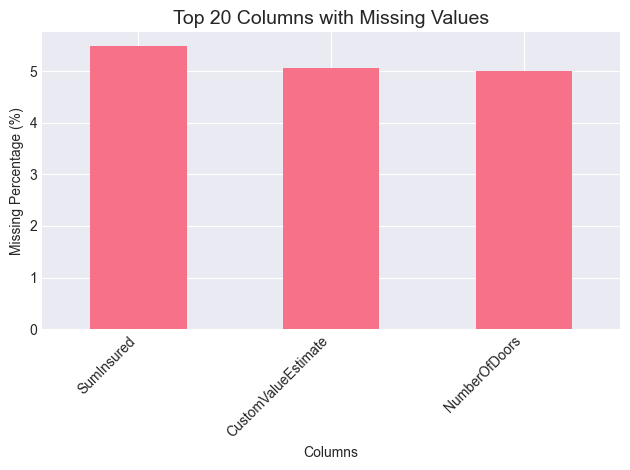

In [3]:
# SECTION 2: DATA QUALITY ASSESSMENT
print("=" * 80)
print("SECTION 2: DATA QUALITY ASSESSMENT")
print("=" * 80)

# Validate data structure
validation_results = processor.validate_data_structure()

# Display data types
print("\nData Types:")
dtype_summary = pd.DataFrame({
    'Column': df.columns,
    'DataType': df.dtypes.astype(str),
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

display(dtype_summary.sort_values('Null Percentage', ascending=False).head(20))

# Missing values analysis
print("\nMissing Values Analysis:")
missing_summary = dtype_summary[dtype_summary['Null Percentage'] > 0].sort_values('Null Percentage', ascending=False)

if len(missing_summary) > 0:
    print(f"Total columns with missing values: {len(missing_summary)}")
    print(f"Total missing values: {df.isnull().sum().sum()}")
    print(f"Overall missing percentage: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")
    
    # Plot missing values
    plt.figure(figsize=(12, 6))
    missing_summary.head(20).plot(kind='bar', x='Column', y='Null Percentage', legend=False)
    plt.title('Top 20 Columns with Missing Values', fontsize=14)
    plt.xlabel('Columns')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

In [4]:
# SECTION 3: DATA PREPROCESSING
print("=" * 80)
print("SECTION 3: DATA PREPROCESSING")
print("=" * 80)

# Preprocess data
df_processed = processor.preprocess_data()

print(f"Original shape: {processor.metadata['original_shape']}")
print(f"Processed shape: {df_processed.shape}")

# Display processed data info
print("\nProcessed Data Info:")
print(f"Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for duplicates
duplicate_count = df_processed.duplicated().sum()
print(f"\nDuplicate rows: {duplicate_count} ({duplicate_count/len(df_processed)*100:.2f}%)")

if duplicate_count > 0:
    print("Removing duplicates...")
    df_processed = df_processed.drop_duplicates()
    print(f"New shape after removing duplicates: {df_processed.shape}")

# Save processed data
processor.save_processed_data()
print("\nProcessed data saved successfully!")

2025-12-06 14:00:31,976 - src.utils.data_loader - INFO - Starting data preprocessing
2025-12-06 14:00:32,031 - src.utils.data_loader - INFO - Filled missing values in CustomValueEstimate with median: 35776.97948924357
2025-12-06 14:00:32,035 - src.utils.data_loader - INFO - Filled missing values in SumInsured with median: 60647.43645831662


SECTION 3: DATA PREPROCESSING


2025-12-06 14:00:32,186 - src.utils.data_loader - INFO - Removed 437 extreme outlier rows
2025-12-06 14:00:32,190 - src.utils.data_loader - INFO - Data preprocessing completed. Final shape: (4563, 23)


Original shape: (5000, 18)
Processed shape: (4563, 23)

Processed Data Info:
Memory usage: 2.75 MB

Duplicate rows: 0 (0.00%)


2025-12-06 14:00:34,129 - src.utils.data_loader - INFO - Processed data saved to data\processed\cleaned_data.parquet
2025-12-06 14:00:34,136 - src.utils.data_loader - INFO - Metadata saved to data\processed\cleaned_data_metadata.json



Processed data saved successfully!


In [5]:
# SECTION 4: DESCRIPTIVE STATISTICS
print("=" * 80)
print("SECTION 4: DESCRIPTIVE STATISTICS")
print("=" * 80)

# Initialize EDA Analyzer
analyzer = EDAAnalyzer(df_processed)

# Compute descriptive statistics
desc_stats = analyzer.compute_descriptive_statistics()

print("Descriptive Statistics for Key Numerical Features:")
key_features = ['TotalPremium', 'TotalClaims', 'LossRatio', 'CustomValueEstimate', 
                'SumInsured', 'CalculatedPremiumPerTerm']

key_stats = desc_stats[desc_stats['feature'].isin(key_features)]
display(key_stats[['feature', 'mean', 'std', 'min', '25%', 'median', '75%', 'max', 
                   'skewness', 'kurtosis', 'missing_pct']])

# Create summary table
summary_table = pd.DataFrame({
    'Metric': [
        'Total Premium', 'Total Claims', 'Average Loss Ratio',
        'Average Premium per Policy', 'Average Claim per Policy',
        'Total Policies', 'Date Range'
    ],
    'Value': [
        f"${df_processed['TotalPremium'].sum():,.0f}",
        f"${df_processed['TotalClaims'].sum():,.0f}",
        f"{df_processed['LossRatio'].mean():.3f}",
        f"${df_processed['TotalPremium'].mean():,.0f}",
        f"${df_processed['TotalClaims'].mean():,.0f}",
        f"{df_processed['PolicyID'].nunique() if 'PolicyID' in df_processed.columns else len(df_processed):,.0f}",
        f"{df_processed['TransactionMonth'].min().date()} to {df_processed['TransactionMonth'].max().date()}"
        if 'TransactionMonth' in df_processed.columns else 'N/A'
    ]
})

print("\nKey Business Metrics Summary:")
display(summary_table)

2025-12-06 14:00:40,728 - src.analysis.eda_analyzer - INFO - Identified 14 numeric columns, 8 categorical columns, 1 date columns
2025-12-06 14:00:40,732 - src.analysis.eda_analyzer - INFO - Computing descriptive statistics


SECTION 4: DESCRIPTIVE STATISTICS


2025-12-06 14:00:40,988 - src.analysis.eda_analyzer - INFO - Computed descriptive statistics for 14 numeric features


Descriptive Statistics for Key Numerical Features:


,feature,mean,std,min,25%,median,75%,max,skewness,kurtosis,missing_pct
1,TotalPremium,6423.030,5108.358,754.611,2822.490,4837.023,8344.116,29934.551,1.709,3.158,0.000
2,TotalClaims,485.874,1210.284,0.000,0.000,0.000,263.825,9078.671,3.623,15.183,0.000
3,CustomValueEstimate,44060.668,30417.623,6803.964,22645.341,35776.979,55867.052,188002.996,1.668,3.284,0.000
4,SumInsured,69159.773,38274.278,15647.602,41418.429,60647.436,85863.894,229402.334,1.320,1.889,0.000
5,CalculatedPremiumPerTerm,3344.809,1585.042,917.735,2179.124,3005.446,4173.983,9498.706,1.055,0.956,0.000
8,LossRatio,0.133,0.430,0.000,0.000,0.000,0.043,9.368,7.859,104.530,0.000



Key Business Metrics Summary:


,Metric,Value
0,Total Premium,"$29,308,285"
1,Total Claims,"$2,217,045"
2,Average Loss Ratio,0.133
3,Average Premium per Policy,"$6,423"
4,Average Claim per Policy,$486
5,Total Policies,"4,563"
6,Date Range,2014-02-01 to 2027-10-10


2025-12-06 14:01:14,386 - src.analysis.eda_analyzer - INFO - Analyzing feature distributions
2025-12-06 14:01:14,535 - src.analysis.eda_analyzer - INFO - Analyzing missing values


SECTION 5: UNIVARIATE ANALYSIS


2025-12-06 14:01:14,706 - src.analysis.eda_analyzer - INFO - Missing values analysis completed. Features with >50% missing: 0


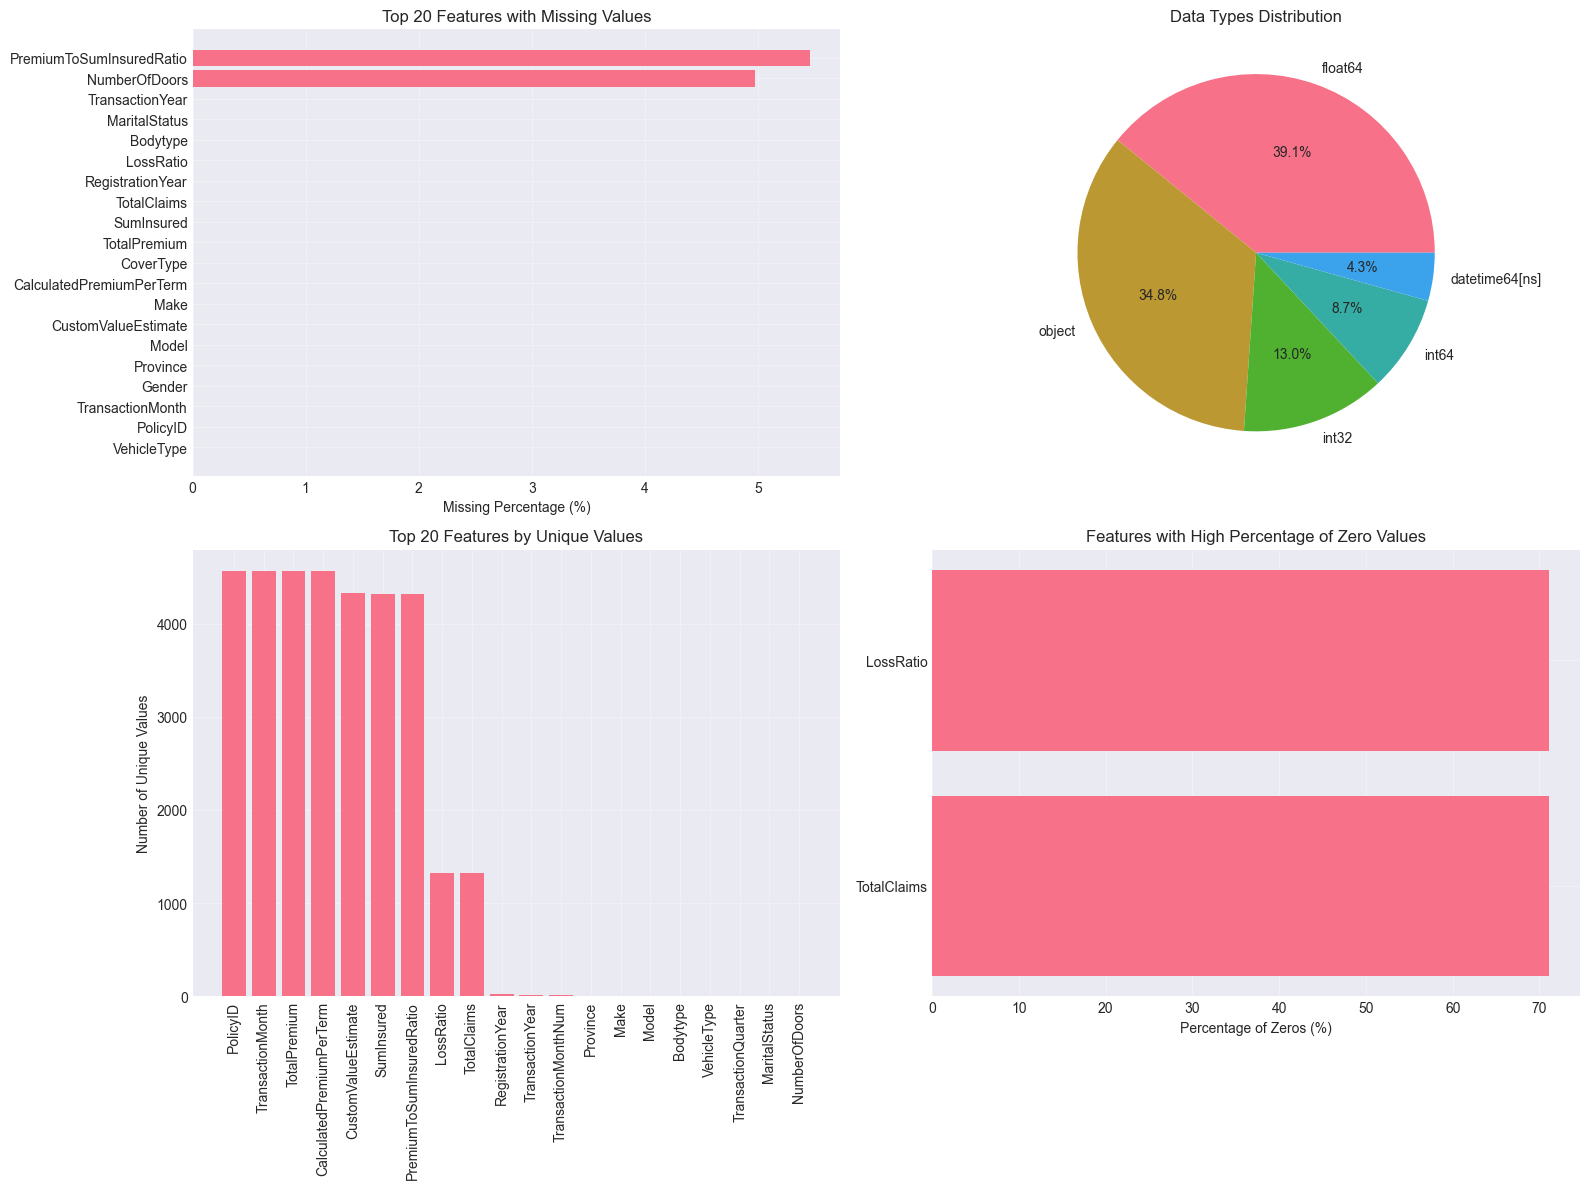


Plotting distributions for 14 numeric columns...


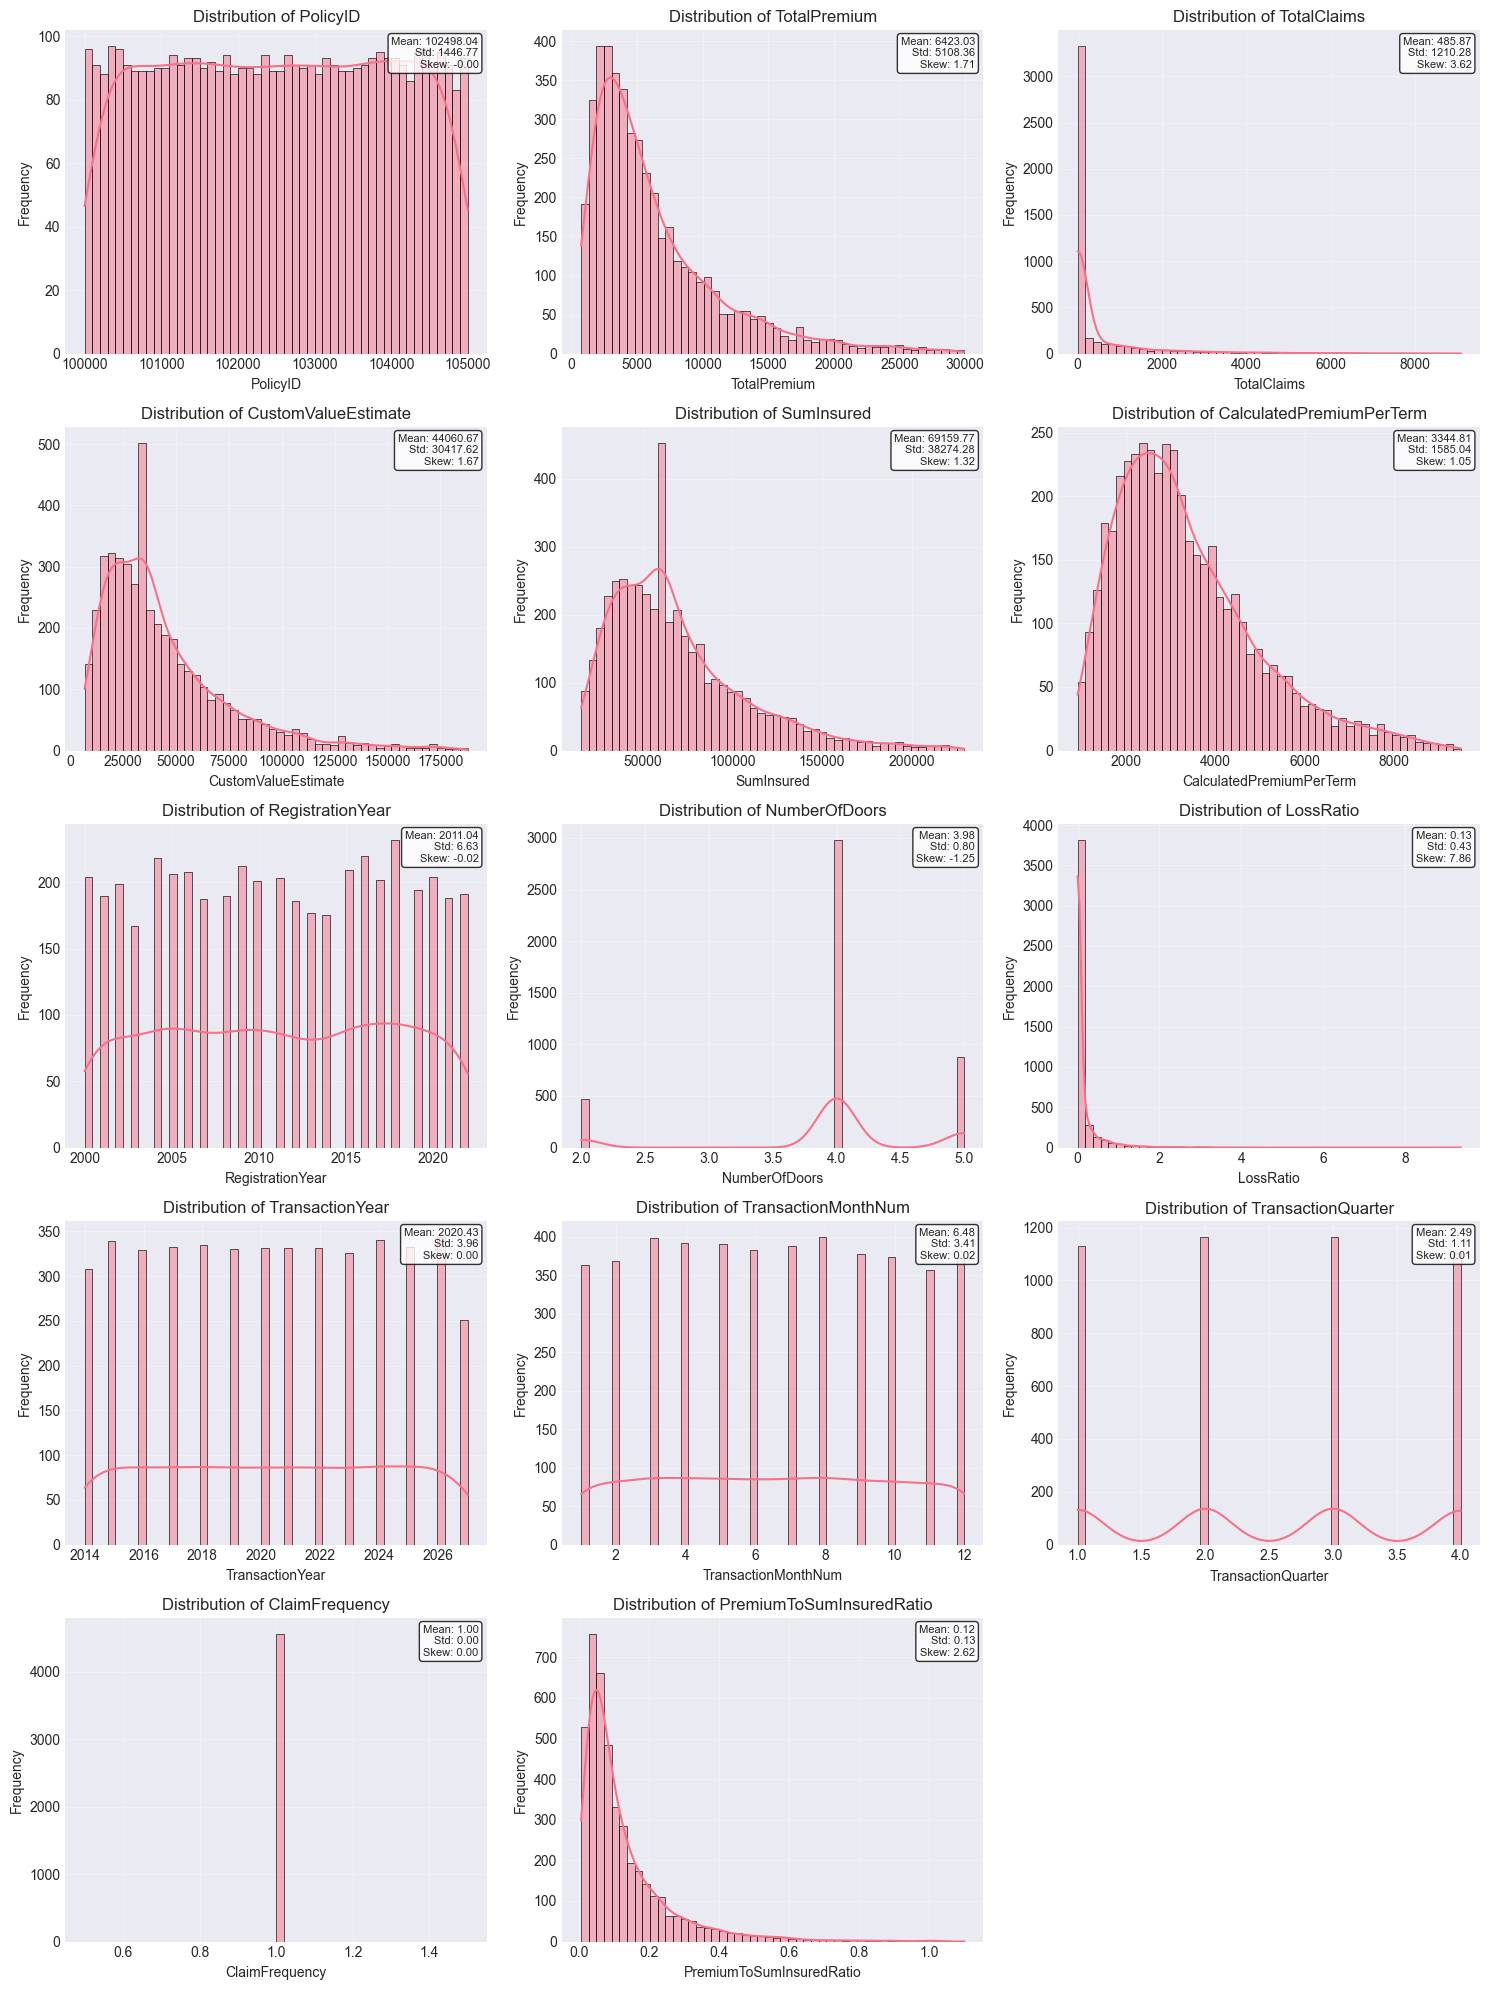


Plotting distributions for 8 categorical columns...


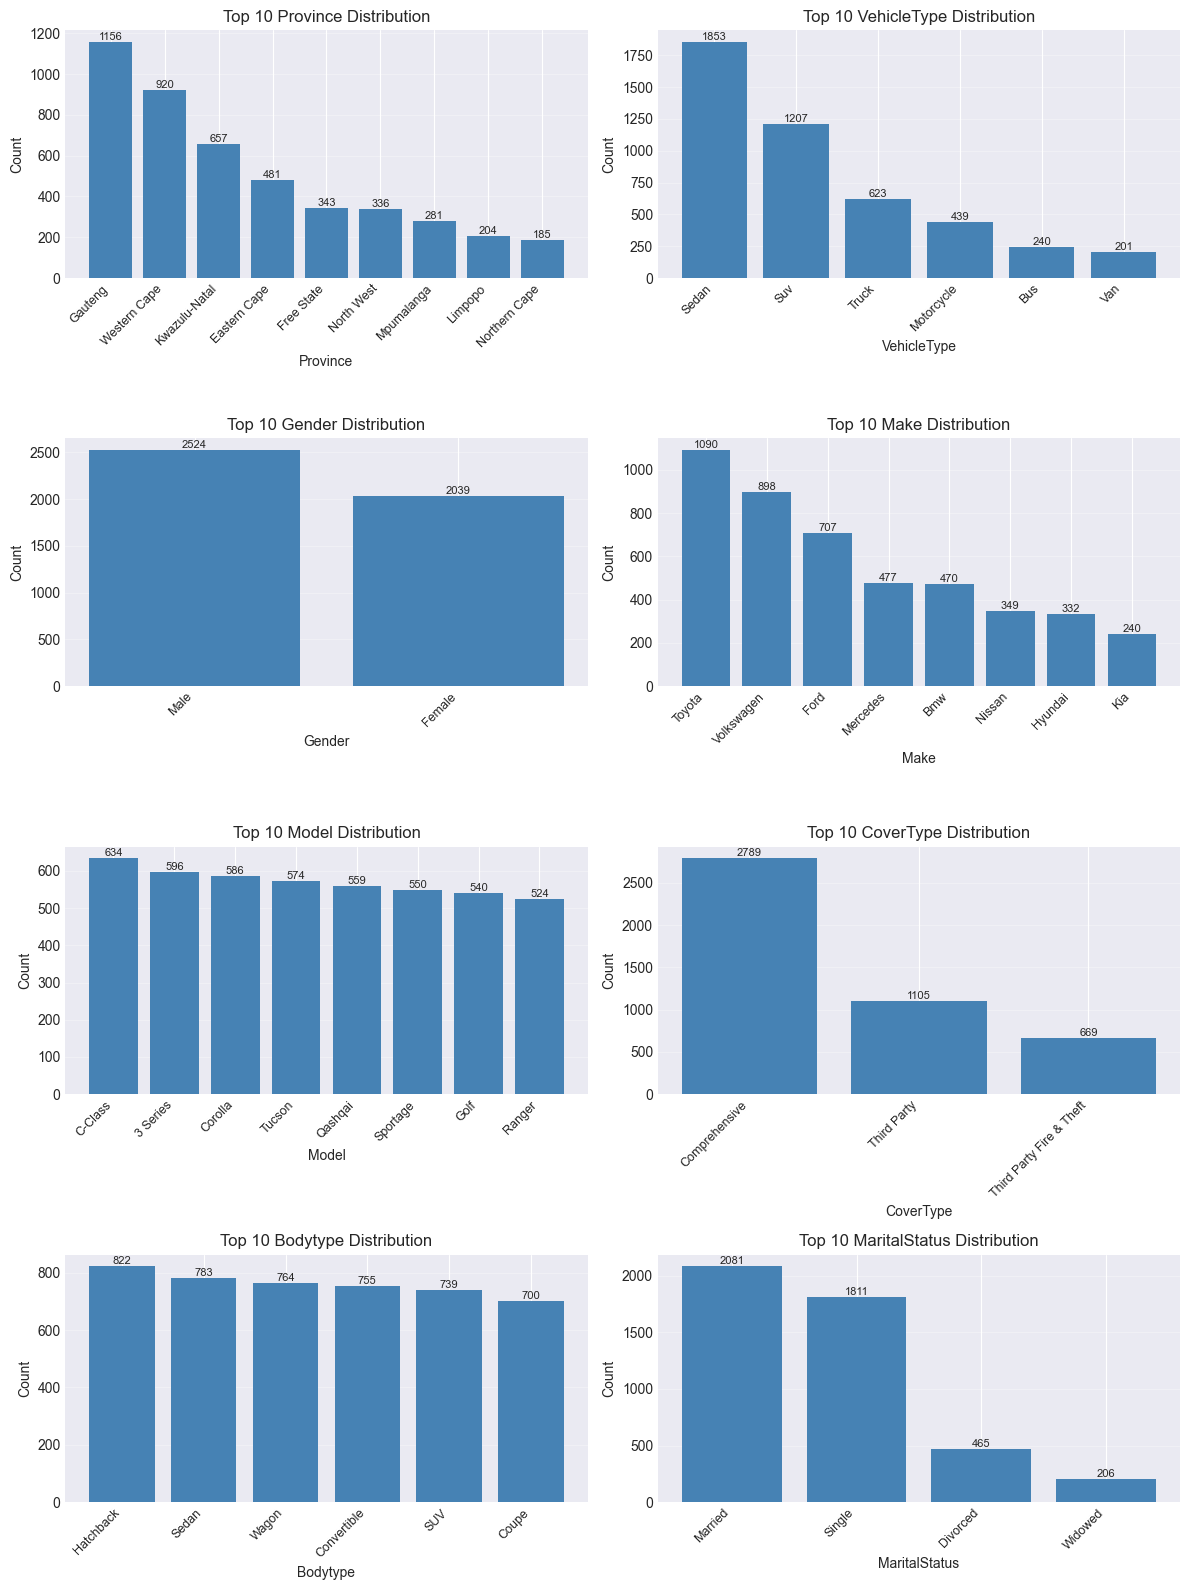


Distribution Insights:

TotalPremium:
  Mean: 6423.03, Median: 4837.02
  Coefficient of Variation: 0.80

TotalClaims:
  Mean: 485.87, Median: 0.00
  Coefficient of Variation: 2.49

LossRatio:
  Mean: 0.13, Median: 0.00
  Coefficient of Variation: 3.24


In [6]:
# SECTION 5: UNIVARIATE ANALYSIS
print("=" * 80)
print("SECTION 5: UNIVARIATE ANALYSIS")
print("=" * 80)

# Initialize visualizer
visualizer = EDAVisualizer(df_processed, save_dir="../reports/figures")

# Analyze distributions
distribution_results = analyzer.analyze_distributions()

# Plot data quality summary
missing_df = analyzer.analyze_missing_values()
visualizer.plot_data_quality_summary(missing_df)

# Plot numeric distributions
numeric_cols = analyzer.numeric_cols[:15]  # First 15 numeric columns
print(f"\nPlotting distributions for {len(numeric_cols)} numeric columns...")
visualizer.plot_numeric_distributions(numeric_cols)

# Plot categorical distributions
categorical_cols = analyzer.categorical_cols[:10]  # First 10 categorical columns
print(f"\nPlotting distributions for {len(categorical_cols)} categorical columns...")
visualizer.plot_categorical_distributions(categorical_cols)

# Display distribution insights
print("\nDistribution Insights:")
for col, stats in distribution_results.get('numeric_distributions', {}).items():
    if col in ['TotalPremium', 'TotalClaims', 'LossRatio']:
        print(f"\n{col}:")
        print(f"  Mean: {stats['mean']:.2f}, Median: {stats['median']:.2f}")
        print(f"  Coefficient of Variation: {stats['coefficient_of_variation']:.2f}"
              if stats['coefficient_of_variation'] else "  Coefficient of Variation: N/A")

2025-12-06 14:01:55,757 - src.analysis.eda_analyzer - INFO - Analyzing correlations using spearman method


SECTION 6: BIVARIATE/MULTIVARIATE ANALYSIS
Analyzing correlations...


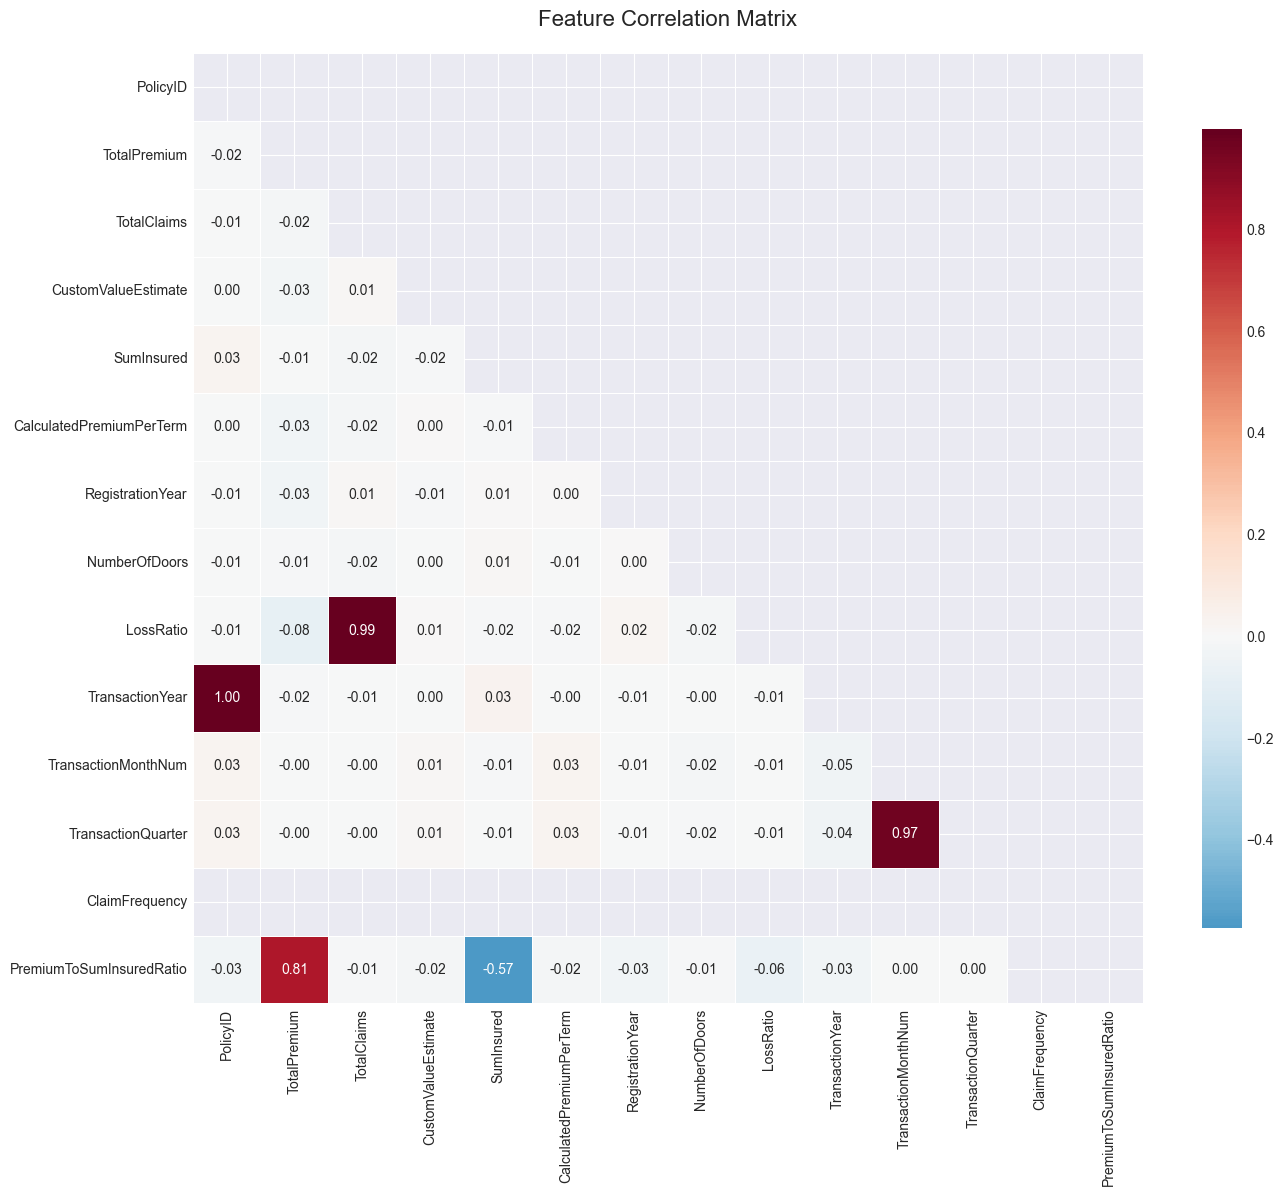


Found 4 highly correlated pairs (|correlation| > 0.7):


,feature_1,feature_2,correlation
0,PolicyID,TransactionYear,0.997
1,TotalPremium,PremiumToSumInsuredRatio,0.806
2,TotalClaims,LossRatio,0.993
3,TransactionMonthNum,TransactionQuarter,0.972



Creating scatter plot matrix for key variables...


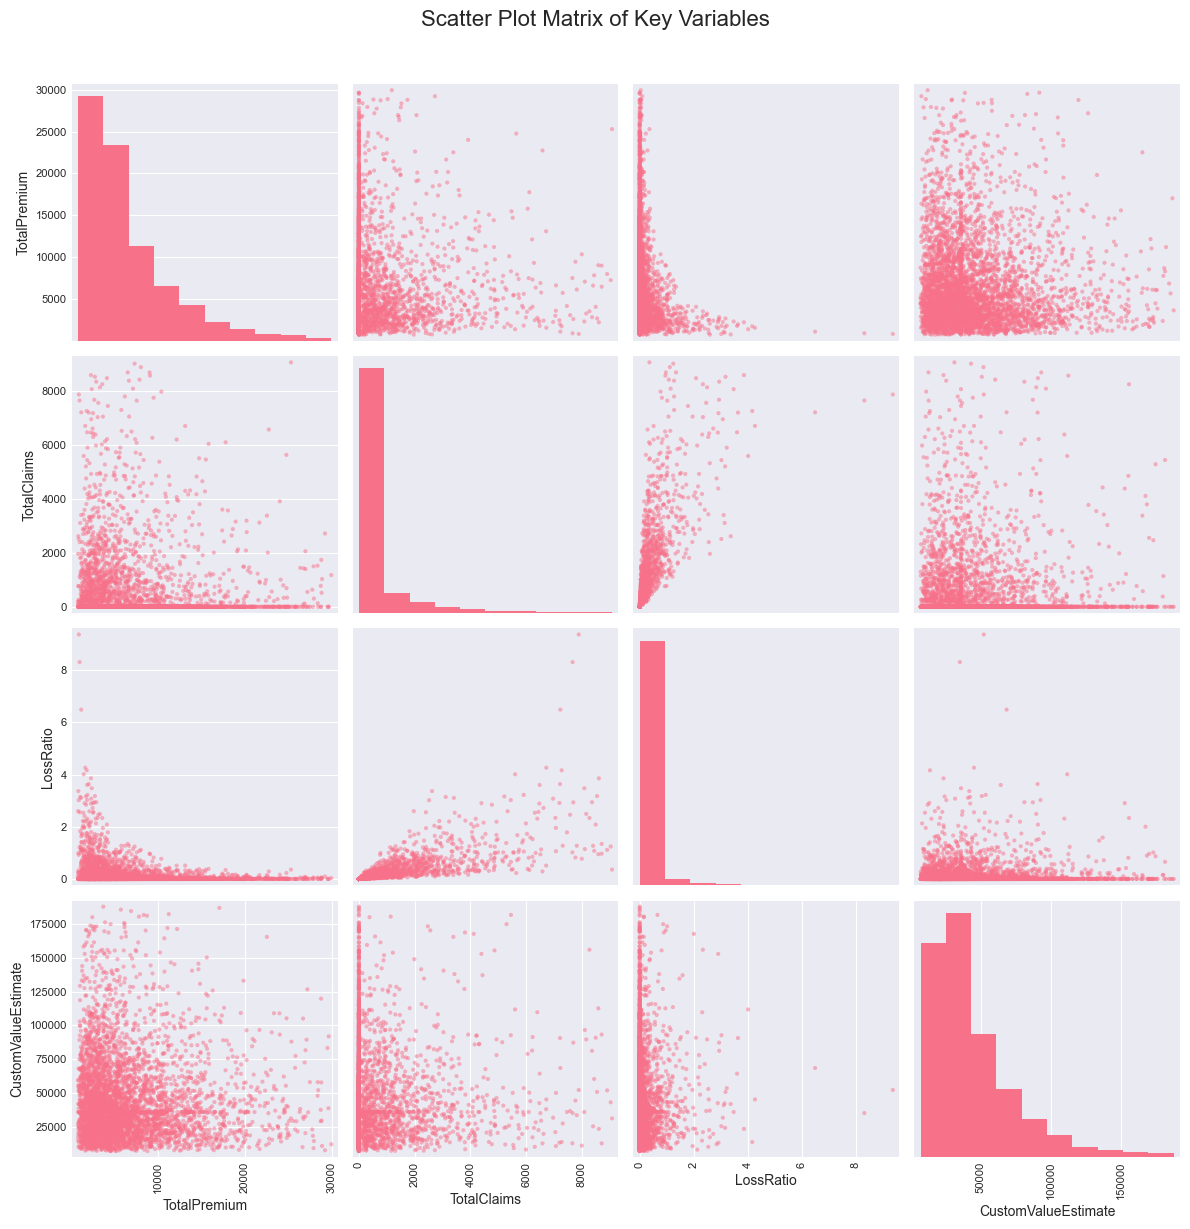


Analyzing pairwise relationships...

Pairwise Relationships Summary:


,Variable 1,Variable 2,Correlation,Relationship
0,TotalPremium,TotalClaims,-0.006,Weak Negative
1,TotalPremium,LossRatio,-0.167,Weak Negative
2,TotalPremium,CustomValueEstimate,-0.018,Weak Negative
3,TotalClaims,LossRatio,0.763,Strong Positive
4,TotalClaims,CustomValueEstimate,0.024,Weak Positive
5,LossRatio,CustomValueEstimate,0.030,Weak Positive


In [7]:
# SECTION 6: BIVARIATE/MULTIVARIATE ANALYSIS
print("=" * 80)
print("SECTION 6: BIVARIATE/MULTIVARIATE ANALYSIS")
print("=" * 80)

# Correlation analysis
print("Analyzing correlations...")
correlation_matrix = analyzer.analyze_correlations(method='spearman')

# Plot correlation matrix
visualizer.plot_correlation_matrix(correlation_matrix)

# Display highly correlated pairs
if 'correlations' in analyzer.results and analyzer.results['correlations'].get('high_correlation_pairs') is not None:
    high_corr = analyzer.results['correlations']['high_correlation_pairs']
    if len(high_corr) > 0:
        print(f"\nFound {len(high_corr)} highly correlated pairs (|correlation| > 0.7):")
        display(high_corr.head(10))
    else:
        print("\nNo highly correlated pairs found (|correlation| > 0.7)")

# Scatter plot matrix for key variables
key_vars = ['TotalPremium', 'TotalClaims', 'LossRatio', 'CustomValueEstimate']
key_df = df_processed[key_vars].dropna()

if len(key_df) > 0:
    print("\nCreating scatter plot matrix for key variables...")
    scatter_matrix = pd.plotting.scatter_matrix(key_df, figsize=(12, 12), diagonal='hist', 
                                               alpha=0.5, grid=True)
    plt.suptitle('Scatter Plot Matrix of Key Variables', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig("../reports/figures/scatter_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

# Pairwise relationships analysis
print("\nAnalyzing pairwise relationships...")
pair_relationships = []

for i, var1 in enumerate(key_vars):
    for var2 in key_vars[i+1:]:
        if var1 in df_processed.columns and var2 in df_processed.columns:
            corr = df_processed[[var1, var2]].corr().iloc[0, 1]
            pair_relationships.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Correlation': corr,
                'Relationship': 'Strong Positive' if corr > 0.7 else
                               'Moderate Positive' if corr > 0.3 else
                               'Weak Positive' if corr > 0 else
                               'Weak Negative' if corr > -0.3 else
                               'Moderate Negative' if corr > -0.7 else
                               'Strong Negative'
            })

pair_df = pd.DataFrame(pair_relationships)
print("\nPairwise Relationships Summary:")
display(pair_df)

In [8]:
# SECTION 7: LOSS RATIO ANALYSIS
print("=" * 80)
print("SECTION 7: LOSS RATIO ANALYSIS")
print("=" * 80)

# Calculate overall loss ratio
overall_loss_ratio = df_processed['LossRatio'].mean()
print(f"\nOverall Portfolio Loss Ratio: {overall_loss_ratio:.3f}")

# Analyze loss ratio by different dimensions
dimensions = ['Province', 'VehicleType', 'Gender', 'CoverType', 'Make']
dimension_results = analyzer.analyze_by_dimensions(dimensions)

# Display loss ratio by province
if 'Province' in dimension_results:
    print("\nLoss Ratio by Province (Top 10):")
    province_loss = dimension_results['Province'].sort_values('LossRatio_mean', ascending=False).head(10)
    display(province_loss[['Province', 'LossRatio_mean', 'TotalPremium_sum', 'TotalClaims_sum', 
                          'Premium_Share', 'Claims_Share']])

# Display loss ratio by vehicle type
if 'VehicleType' in dimension_results:
    print("\nLoss Ratio by Vehicle Type:")
    vehicle_loss = dimension_results['VehicleType'].sort_values('LossRatio_mean', ascending=False)
    display(vehicle_loss[['VehicleType', 'LossRatio_mean', 'TotalPremium_sum', 'TotalClaims_sum']])

# Display loss ratio by gender
if 'Gender' in dimension_results:
    print("\nLoss Ratio by Gender:")
    gender_loss = dimension_results['Gender'].sort_values('LossRatio_mean', ascending=False)
    display(gender_loss[['Gender', 'LossRatio_mean', 'TotalPremium_sum', 'TotalClaims_sum']])

# Plot loss ratio analysis
visualizer.plot_loss_ratio_analysis()

# Create detailed loss ratio report
print("\n" + "=" * 80)
print("LOSS RATIO INSIGHTS SUMMARY")
print("=" * 80)

loss_ratio_insights = []

# Provincial insights
if 'Province' in dimension_results:
    highest_province = dimension_results['Province'].loc[dimension_results['Province']['LossRatio_mean'].idxmax()]
    lowest_province = dimension_results['Province'].loc[dimension_results['Province']['LossRatio_mean'].idxmin()]
    
    loss_ratio_insights.append({
        'Insight': f"Highest Loss Ratio Province: {highest_province['Province']}",
        'Value': f"{highest_province['LossRatio_mean']:.3f}",
        'Interpretation': f"Claims are {highest_province['LossRatio_mean']/overall_loss_ratio:.1f}x portfolio average"
    })
    
    loss_ratio_insights.append({
        'Insight': f"Lowest Loss Ratio Province: {lowest_province['Province']}",
        'Value': f"{lowest_province['LossRatio_mean']:.3f}",
        'Interpretation': f"Claims are {lowest_province['LossRatio_mean']/overall_loss_ratio:.1f}x portfolio average"
    })

# Vehicle type insights
if 'VehicleType' in dimension_results:
    highest_vehicle = dimension_results['VehicleType'].loc[dimension_results['VehicleType']['LossRatio_mean'].idxmax()]
    
    loss_ratio_insights.append({
        'Insight': f"Highest Risk Vehicle Type: {highest_vehicle['VehicleType']}",
        'Value': f"{highest_vehicle['LossRatio_mean']:.3f}",
        'Interpretation': f"Consider adjusting premiums or coverage for this vehicle type"
    })

# Gender insights
if 'Gender' in dimension_results:
    gender_comparison = dimension_results['Gender']
    if len(gender_comparison) >= 2:
        gender_diff = gender_comparison['LossRatio_mean'].max() - gender_comparison['LossRatio_mean'].min()
        
        loss_ratio_insights.append({
            'Insight': "Gender-based Loss Ratio Difference",
            'Value': f"{gender_diff:.3f}",
            'Interpretation': f"Significant difference in loss ratios between genders"
        })

insights_df = pd.DataFrame(loss_ratio_insights)
display(insights_df)

2025-12-06 14:02:26,019 - src.analysis.eda_analyzer - INFO - Analyzing by dimensions: ['Province', 'VehicleType', 'Gender', 'CoverType', 'Make']


SECTION 7: LOSS RATIO ANALYSIS

Overall Portfolio Loss Ratio: 0.133

Loss Ratio by Province (Top 10):


,Province,LossRatio_mean,TotalPremium_sum,TotalClaims_sum,Premium_Share,Claims_Share
7,Northern Cape,0.228,1151717.478,124722.950,3.930,5.626
5,Mpumalanga,0.171,1774184.857,162372.640,6.054,7.324
4,Limpopo,0.160,1297589.171,120117.434,4.427,5.418
0,Eastern Cape,0.140,2873473.397,232177.978,9.804,10.472
8,Western Cape,0.126,5940652.713,441962.534,20.270,19.935
2,Gauteng,0.122,7397506.362,524390.992,25.240,23.653
6,North West,0.119,2181819.398,140062.856,7.444,6.318
3,Kwazulu-Natal,0.118,4366246.249,308326.787,14.898,13.907
1,Free State,0.116,2325095.830,162911.140,7.933,7.348



Loss Ratio by Vehicle Type:


,VehicleType,LossRatio_mean,TotalPremium_sum,TotalClaims_sum
3,Suv,0.145,7588365.943,648459.737
0,Bus,0.139,1589610.931,105192.920
2,Sedan,0.136,11748619.798,883489.517
1,Motorcycle,0.119,2865884.528,194585.452
4,Truck,0.119,4164561.535,293117.900
5,Van,0.091,1351242.721,92199.785



Loss Ratio by Gender:


,Gender,LossRatio_mean,TotalPremium_sum,TotalClaims_sum
0,Female,0.148,13168495.546,1051992.580
1,Male,0.120,16139789.909,1165052.731



LOSS RATIO INSIGHTS SUMMARY


,Insight,Value,Interpretation
0,Highest Loss Ratio Province: Northern Cape,0.228,Claims are 1.7x portfolio average
1,Lowest Loss Ratio Province: Free State,0.116,Claims are 0.9x portfolio average
2,Highest Risk Vehicle Type: Suv,0.145,Consider adjusting premiums or coverage for th...
3,Gender-based Loss Ratio Difference,0.028,Significant difference in loss ratios between ...


2025-12-06 14:02:58,351 - src.analysis.eda_analyzer - INFO - Detecting outliers using iqr method


SECTION 8: OUTLIER DETECTION


2025-12-06 14:02:58,526 - src.analysis.eda_analyzer - INFO - Detected outliers in 8 features affecting 2579 records



Outlier Detection Summary:
Total records with outliers: 2,579 (56.52%)
Features with outliers: 8

Top 10 Features with Most Outliers:


,Feature,Outliers,Percentage,Lower Bound,Upper Bound
5,NumberOfDoors,1354,29.673,4.000,4.000
6,LossRatio,928,20.337,-0.064,0.107
1,TotalClaims,867,19.001,-395.737,659.562
7,PremiumToSumInsuredRatio,307,6.728,-0.132,0.332
0,TotalPremium,254,5.567,-5459.949,16626.554
2,CustomValueEstimate,236,5.172,-27187.225,105699.618
3,SumInsured,185,4.054,-25249.769,152532.091
4,CalculatedPremiumPerTerm,145,3.178,-813.165,7166.272


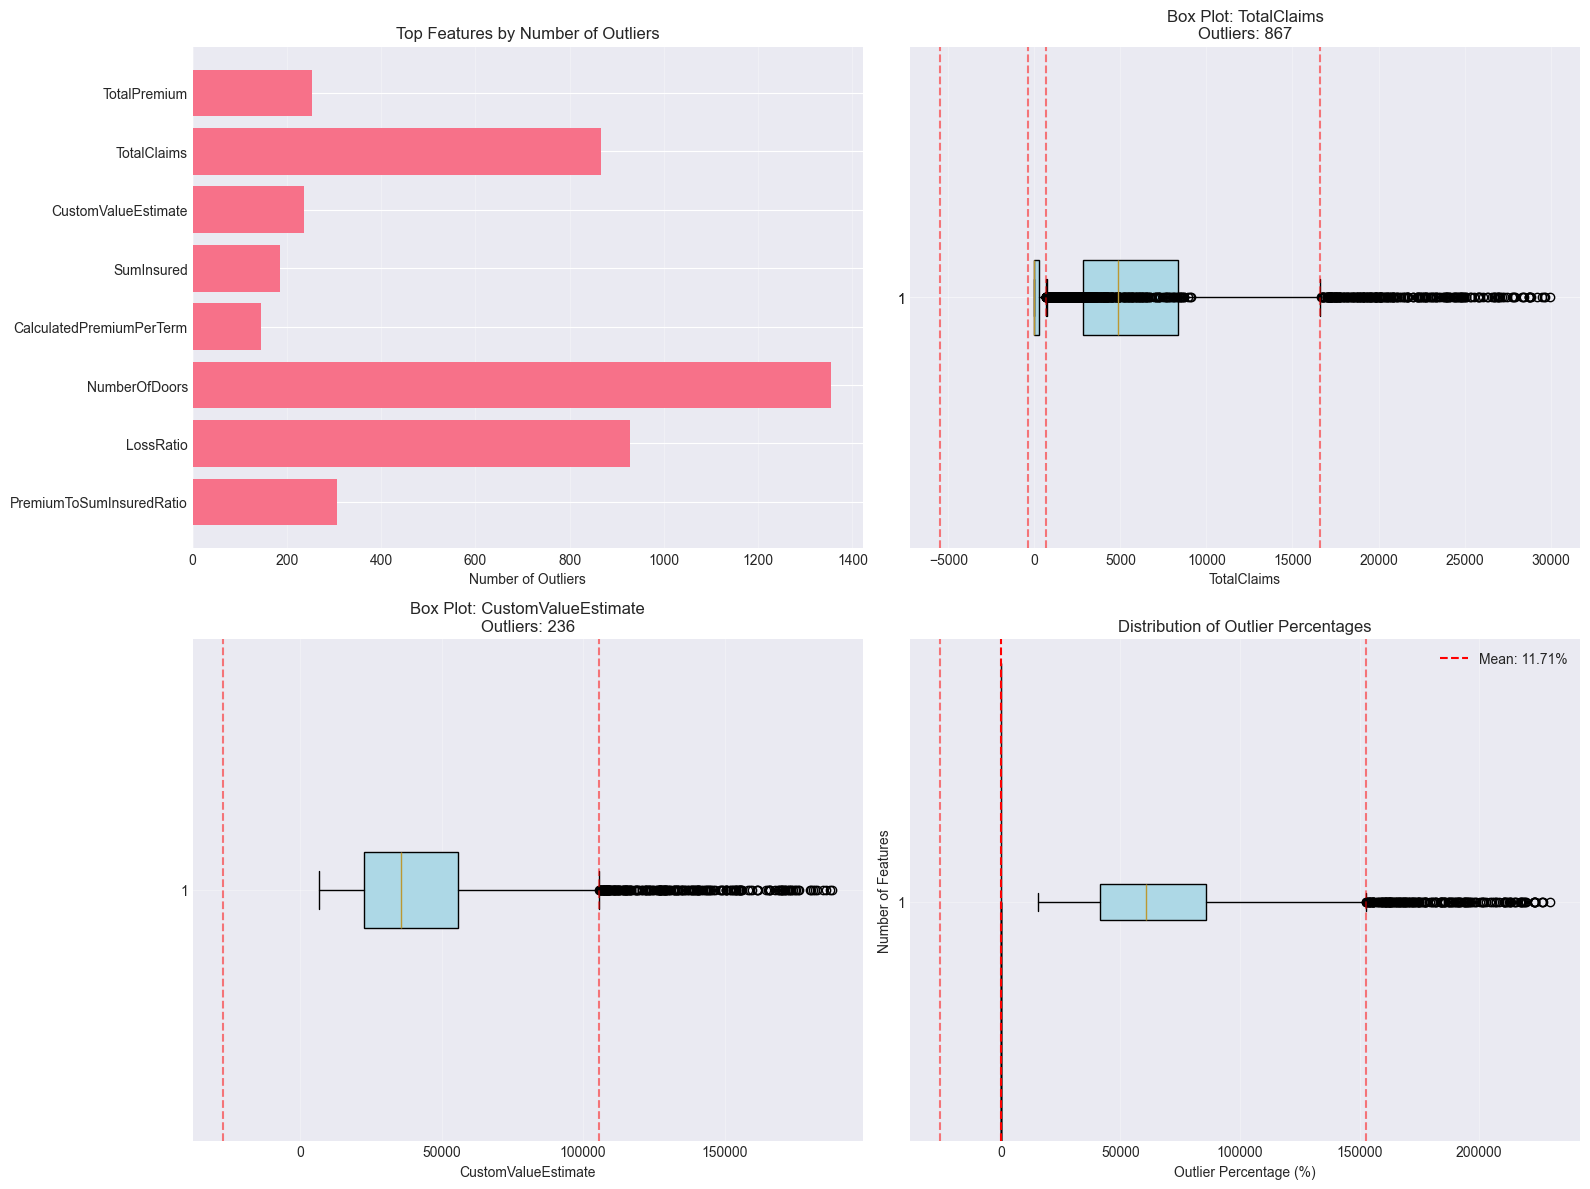


Analyzing impact of outliers on key metrics...

TotalClaims:
  Outliers contribute: $2,063,063 (93.1% of total)
  Number of outlier records: 867 (19.0% of records)

TotalPremium:
  Outliers contribute: $5,401,244 (18.4% of total)
  Number of outlier records: 254 (5.6% of records)

CustomValueEstimate:
  Outliers contribute: $31,534,944 (15.7% of total)
  Number of outlier records: 236 (5.2% of records)


In [9]:
# SECTION 8: OUTLIER DETECTION
print("=" * 80)
print("SECTION 8: OUTLIER DETECTION")
print("=" * 80)

# Detect outliers
outlier_results = analyzer.detect_outliers(method='iqr', threshold=1.5)

# Display outlier summary
if 'summary' in outlier_results:
    summary = outlier_results['summary']
    print(f"\nOutlier Detection Summary:")
    print(f"Total records with outliers: {summary['total_outlier_records']:,} "
          f"({summary['percentage_outlier_records']:.2f}%)")
    print(f"Features with outliers: {summary['features_with_outliers']}")

# Display top features with most outliers
if 'outliers_by_feature' in outlier_results:
    outlier_features = []
    for feature, stats in outlier_results['outliers_by_feature'].items():
        if stats['count'] > 0:
            outlier_features.append({
                'Feature': feature,
                'Outliers': stats['count'],
                'Percentage': stats['percentage'],
                'Lower Bound': stats.get('lower_bound', 'N/A'),
                'Upper Bound': stats.get('upper_bound', 'N/A')
            })
    
    if outlier_features:
        outlier_df = pd.DataFrame(outlier_features).sort_values('Outliers', ascending=False)
        print(f"\nTop 10 Features with Most Outliers:")
        display(outlier_df.head(10))
        
        # Plot outlier analysis
        visualizer.plot_outlier_analysis(outlier_results)
        
        # Analyze impact of outliers on key metrics
        print("\nAnalyzing impact of outliers on key metrics...")
        
        for feature in ['TotalClaims', 'TotalPremium', 'CustomValueEstimate']:
            if feature in outlier_results['outliers_by_feature']:
                stats = outlier_results['outliers_by_feature'][feature]
                if stats['count'] > 0:
                    outlier_indices = stats['outlier_indices']
                    outlier_sum = df_processed.loc[outlier_indices, feature].sum()
                    total_sum = df_processed[feature].sum()
                    
                    print(f"\n{feature}:")
                    print(f"  Outliers contribute: ${outlier_sum:,.0f} "
                          f"({outlier_sum/total_sum*100:.1f}% of total)")
                    print(f"  Number of outlier records: {stats['count']:,} "
                          f"({stats['percentage']:.1f}% of records)")
    else:
        print("\nNo outliers detected in any features!")
else:
    print("\nOutlier detection results not available!")

In [10]:
# SECTION 9: TEMPORAL TREND ANALYSIS
print("=" * 80)
print("SECTION 9: TEMPORAL TREND ANALYSIS")
print("=" * 80)

# Analyze temporal trends
temporal_results = analyzer.analyze_temporal_trends()

if 'monthly_data' in temporal_results:
    monthly_data = temporal_results['monthly_data']
    
    print(f"\nTemporal Analysis Period: {monthly_data.index[0].date()} to {monthly_data.index[-1].date()}")
    print(f"Number of months analyzed: {len(monthly_data)}")
    
    # Display monthly summary
    print("\nMonthly Summary Statistics:")
    monthly_summary = monthly_data.describe()
    display(monthly_summary)
    
    # Calculate trends
    print("\nTrend Analysis:")
    for key in ['TotalPremium_trend', 'TotalClaims_trend', 'LossRatio_trend']:
        if key in temporal_results:
            trend = temporal_results[key]
            direction = '📈 Increasing' if trend['slope'] > 0 else '📉 Decreasing'
            significance = 'Significant' if trend['p_value'] < 0.05 else 'Not Significant'
            
            print(f"\n{key.replace('_trend', '').replace('Total', '')}:")
            print(f"  Direction: {direction} (slope: {trend['slope']:.4f})")
            print(f"  R-squared: {trend['r_squared']:.3f}")
            print(f"  P-value: {trend['p_value']:.4f} ({significance})")
            print(f"  Percent Change: {trend['percent_change']:.1f}% over period")
    
    # Plot temporal trends
    visualizer.plot_temporal_trends(monthly_data)
    
    # Monthly volatility analysis
    print("\nMonthly Volatility Analysis:")
    volatility_stats = {
        'Metric': ['TotalPremium', 'TotalClaims', 'LossRatio'],
        'Std_Dev': [monthly_data['TotalPremium'].std(), 
                   monthly_data['TotalClaims'].std(), 
                   monthly_data['LossRatio'].std()],
        'CV': [monthly_data['TotalPremium'].std() / monthly_data['TotalPremium'].mean(),
              monthly_data['TotalClaims'].std() / monthly_data['TotalClaims'].mean(),
              monthly_data['LossRatio'].std() / monthly_data['LossRatio'].mean()]
    }
    
    volatility_df = pd.DataFrame(volatility_stats)
    display(volatility_df)
    
    # Identify peak months
    print("\nPeak Months Analysis:")
    peak_months = {
        'Highest Premium Month': monthly_data['TotalPremium'].idxmax().strftime('%B %Y'),
        'Highest Claims Month': monthly_data['TotalClaims'].idxmax().strftime('%B %Y'),
        'Highest Loss Ratio Month': monthly_data['LossRatio'].idxmax().strftime('%B %Y'),
        'Lowest Loss Ratio Month': monthly_data['LossRatio'].idxmin().strftime('%B %Y')
    }
    
    for metric, month in peak_months.items():
        print(f"  {metric}: {month}")
else:
    print("Temporal analysis not available. Check if 'TransactionMonth' column exists.")

2025-12-06 14:03:27,356 - src.analysis.eda_analyzer - INFO - Analyzing temporal trends using TransactionMonth


SECTION 9: TEMPORAL TREND ANALYSIS

Temporal Analysis Period: 2014-02-28 to 2027-10-31
Number of months analyzed: 165

Monthly Summary Statistics:


,TotalPremium,TotalClaims,PolicyID,LossRatio,AvgClaim,AvgPremium
count,165.000,165.000,165.000,165.000,165.000,165.000
mean,177625.972,13436.638,27.655,0.078,486.893,6415.230
std,28804.639,6642.096,2.171,0.042,236.590,914.047
min,34199.066,451.669,8.000,0.002,16.728,4102.880
25%,162237.372,8314.568,27.000,0.049,312.466,5830.481
50%,178507.866,12536.502,28.000,0.071,459.682,6431.041
75%,194073.980,17074.722,29.000,0.101,626.989,7064.334
max,258810.183,35012.175,31.000,0.216,1250.435,9553.833



Trend Analysis:

Premium:
  Direction: 📉 Decreasing (slope: -70.0480)
  R-squared: 0.013
  P-value: 0.1373 (Not Significant)
  Percent Change: -80.1% over period

Claims:
  Direction: 📉 Decreasing (slope: -1.8203)
  R-squared: 0.000
  P-value: 0.8674 (Not Significant)
  Percent Change: -50.8% over period

LossRatio:
  Direction: 📈 Increasing (slope: 0.0000)
  R-squared: 0.003
  P-value: 0.5189 (Not Significant)
  Percent Change: 147.1% over period



Monthly Volatility Analysis:


,Metric,Std_Dev,CV
0,TotalPremium,28804.639,0.162
1,TotalClaims,6642.096,0.494
2,LossRatio,0.042,0.535



Peak Months Analysis:
  Highest Premium Month: March 2024
  Highest Claims Month: May 2016
  Highest Loss Ratio Month: August 2022
  Lowest Loss Ratio Month: February 2027


SECTION 10: VEHICLE MAKE/MODEL ANALYSIS

Analyzed 64 unique make/model combinations (with >5 policies each)

Top 10 Vehicle Makes/Models by Total Claims:


,Make,Model,TotalClaims_sum,TotalClaims_mean,LossRatio_mean,TotalClaims_count
54,Toyota,Sportage,108830.720,782.950,0.220,139
49,Toyota,C-Class,76707.330,498.100,0.110,154
48,Toyota,3 Series,75174.830,529.400,0.180,142
59,Volkswagen,Golf,73468.760,674.030,0.170,109
52,Toyota,Qashqai,71501.440,525.750,0.130,136
61,Volkswagen,Ranger,69853.650,629.310,0.170,111
57,Volkswagen,C-Class,69659.190,657.160,0.210,106
56,Volkswagen,3 Series,65738.600,571.640,0.170,115
53,Toyota,Ranger,63889.330,532.410,0.110,120
55,Toyota,Tucson,59090.630,461.650,0.100,128



Top 10 Vehicle Makes/Models by Loss Ratio (Highest Risk):


,Make,Model,LossRatio_mean,TotalClaims_sum,TotalPremium_sum,TotalClaims_count
38,Mercedes,Sportage,0.260,34529.070,301830.400,49
17,Hyundai,C-Class,0.220,50377.160,339356.350,54
47,Nissan,Tucson,0.220,29619.520,332395.060,46
54,Toyota,Sportage,0.220,108830.720,1014618.790,139
35,Mercedes,Golf,0.210,40890.980,436280.780,64
57,Volkswagen,C-Class,0.210,69659.190,580259.400,106
15,Ford,Tucson,0.200,44864.440,438382.950,75
46,Nissan,Sportage,0.190,14063.560,152383.300,35
48,Toyota,3 Series,0.180,75174.830,913688.890,142
36,Mercedes,Qashqai,0.180,30076.720,385462.290,64



Top 10 Vehicle Makes/Models by Loss Ratio (Lowest Risk):


,Make,Model,LossRatio_mean,TotalClaims_sum,TotalPremium_sum,TotalClaims_count
27,Kia,Golf,0.010,3550.250,169896.990,24
23,Hyundai,Tucson,0.040,12326.320,258690.740,39
30,Kia,Sportage,0.040,4991.010,185431.640,26
41,Nissan,C-Class,0.040,7731.260,331169.460,52
7,Bmw,Tucson,0.050,13229.090,396484.910,63
1,Bmw,C-Class,0.060,16259.640,451503.020,68
45,Nissan,Ranger,0.060,11254.560,286027.660,47
31,Kia,Tucson,0.070,13177.600,183843.490,29
40,Nissan,3 Series,0.070,14930.720,305922.230,48
34,Mercedes,Corolla,0.070,13028.020,344645.200,56



Vehicle Make Analysis (Aggregated):

Analyzed 8 makes (with >10 policies each)

Top 10 Risky Makes by Loss Ratio:


,Make,LossRatio,TotalClaims,TotalPremium,PolicyID,Claims_Share,Premium_Share
2,Hyundai,0.085,194448.963,2298651.816,332,8.771,7.843
4,Mercedes,0.082,233559.036,2855797.928,477,10.535,9.744
7,Volkswagen,0.082,469821.300,5763991.100,898,21.191,19.667
6,Toyota,0.079,563599.721,7152669.958,1090,25.421,24.405
1,Ford,0.078,358391.389,4580730.065,707,16.165,15.629
5,Nissan,0.065,135794.277,2074667.209,349,6.125,7.079
0,Bmw,0.062,193771.734,3114461.303,470,8.740,10.627
3,Kia,0.046,67658.892,1467316.076,240,3.052,5.006



Top 10 Safest Makes by Loss Ratio:


,Make,LossRatio,TotalClaims,TotalPremium,PolicyID,Claims_Share,Premium_Share
3,Kia,0.046,67658.892,1467316.076,240,3.052,5.006
0,Bmw,0.062,193771.734,3114461.303,470,8.740,10.627
5,Nissan,0.065,135794.277,2074667.209,349,6.125,7.079
1,Ford,0.078,358391.389,4580730.065,707,16.165,15.629
6,Toyota,0.079,563599.721,7152669.958,1090,25.421,24.405
7,Volkswagen,0.082,469821.300,5763991.100,898,21.191,19.667
4,Mercedes,0.082,233559.036,2855797.928,477,10.535,9.744
2,Hyundai,0.085,194448.963,2298651.816,332,8.771,7.843


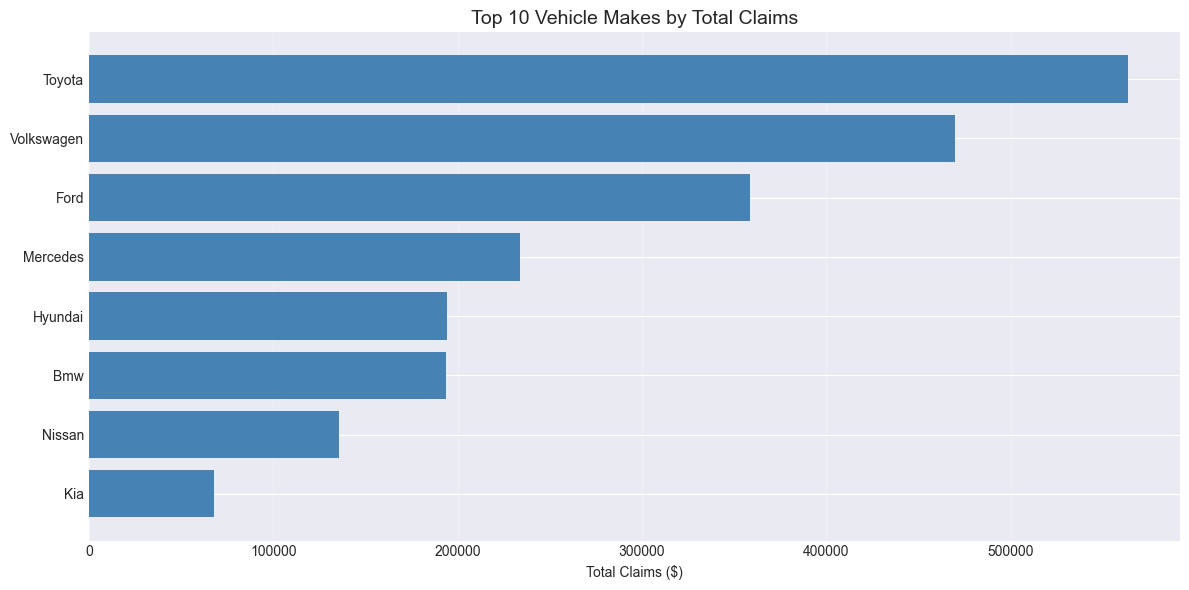

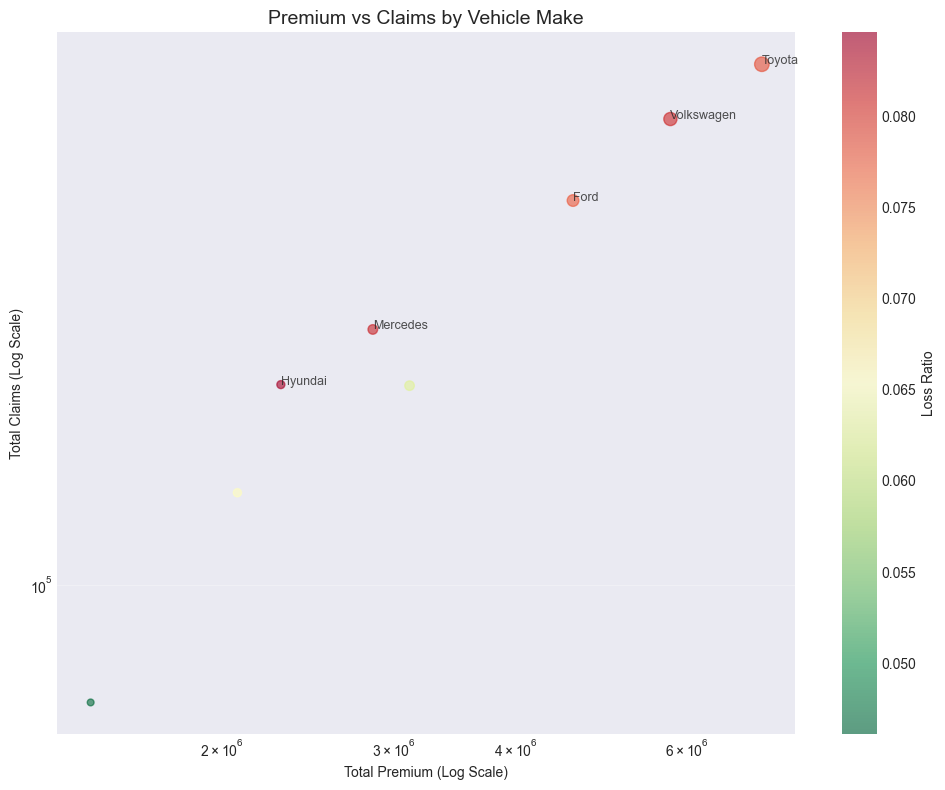

In [11]:
# SECTION 10: VEHICLE MAKE/MODEL ANALYSIS
print("=" * 80)
print("SECTION 10: VEHICLE MAKE/MODEL ANALYSIS")
print("=" * 80)

if all(col in df_processed.columns for col in ['Make', 'Model', 'TotalClaims']):
    # Analyze vehicle makes and models
    vehicle_analysis = df_processed.groupby(['Make', 'Model']).agg({
        'TotalClaims': ['sum', 'mean', 'count'],
        'TotalPremium': ['sum', 'mean'],
        'LossRatio': ['mean', 'std'],
        'CustomValueEstimate': 'mean'
    }).round(2)
    
    # Flatten column names
    vehicle_analysis.columns = ['_'.join(col).strip() for col in vehicle_analysis.columns.values]
    vehicle_analysis = vehicle_analysis.reset_index()
    
    # Filter for sufficient data
    vehicle_analysis = vehicle_analysis[vehicle_analysis['TotalClaims_count'] > 5]
    
    print(f"\nAnalyzed {len(vehicle_analysis)} unique make/model combinations "
          f"(with >5 policies each)")
    
    # Top 10 by total claims
    print("\nTop 10 Vehicle Makes/Models by Total Claims:")
    top_claims = vehicle_analysis.sort_values('TotalClaims_sum', ascending=False).head(10)
    display(top_claims[['Make', 'Model', 'TotalClaims_sum', 'TotalClaims_mean', 
                       'LossRatio_mean', 'TotalClaims_count']])
    
    # Top 10 by loss ratio
    print("\nTop 10 Vehicle Makes/Models by Loss Ratio (Highest Risk):")
    top_risk = vehicle_analysis.sort_values('LossRatio_mean', ascending=False).head(10)
    display(top_risk[['Make', 'Model', 'LossRatio_mean', 'TotalClaims_sum', 
                     'TotalPremium_sum', 'TotalClaims_count']])
    
    # Bottom 10 by loss ratio
    print("\nTop 10 Vehicle Makes/Models by Loss Ratio (Lowest Risk):")
    bottom_risk = vehicle_analysis.sort_values('LossRatio_mean', ascending=True).head(10)
    display(bottom_risk[['Make', 'Model', 'LossRatio_mean', 'TotalClaims_sum', 
                        'TotalPremium_sum', 'TotalClaims_count']])
    
    # Make-level analysis
    print("\nVehicle Make Analysis (Aggregated):")
    make_analysis = df_processed.groupby('Make').agg({
        'TotalClaims': 'sum',
        'TotalPremium': 'sum',
        'LossRatio': 'mean',
        'PolicyID': 'count'
    }).reset_index()
    
    make_analysis = make_analysis[make_analysis['PolicyID'] > 10]  # Filter for sufficient data
    make_analysis['LossRatio'] = make_analysis['TotalClaims'] / make_analysis['TotalPremium']
    make_analysis['Premium_Share'] = (make_analysis['TotalPremium'] / make_analysis['TotalPremium'].sum()) * 100
    make_analysis['Claims_Share'] = (make_analysis['TotalClaims'] / make_analysis['TotalClaims'].sum()) * 100
    
    print(f"\nAnalyzed {len(make_analysis)} makes (with >10 policies each)")
    
    # Display top risky makes
    print("\nTop 10 Risky Makes by Loss Ratio:")
    display(make_analysis.sort_values('LossRatio', ascending=False).head(10)[
        ['Make', 'LossRatio', 'TotalClaims', 'TotalPremium', 'PolicyID', 'Claims_Share', 'Premium_Share']
    ])
    
    # Display safest makes
    print("\nTop 10 Safest Makes by Loss Ratio:")
    display(make_analysis.sort_values('LossRatio', ascending=True).head(10)[
        ['Make', 'LossRatio', 'TotalClaims', 'TotalPremium', 'PolicyID', 'Claims_Share', 'Premium_Share']
    ])
    
    # Create visualizations
    # 1. Bar chart of top 10 makes by claims
    plt.figure(figsize=(12, 6))
    top_makes = make_analysis.sort_values('TotalClaims', ascending=False).head(10)
    plt.barh(top_makes['Make'], top_makes['TotalClaims'], color='steelblue')
    plt.xlabel('Total Claims ($)')
    plt.title('Top 10 Vehicle Makes by Total Claims', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig("../reports/figures/top_makes_claims.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Scatter plot: Premium vs Claims by Make
    plt.figure(figsize=(10, 8))
    plt.scatter(make_analysis['TotalPremium'], make_analysis['TotalClaims'], 
               s=make_analysis['PolicyID']/10, alpha=0.6, c=make_analysis['LossRatio'], 
               cmap='RdYlGn_r')
    plt.colorbar(label='Loss Ratio')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Total Premium (Log Scale)')
    plt.ylabel('Total Claims (Log Scale)')
    plt.title('Premium vs Claims by Vehicle Make', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Annotate top makes
    for idx, row in make_analysis.nlargest(5, 'TotalClaims').iterrows():
        plt.annotate(row['Make'], (row['TotalPremium'], row['TotalClaims']),
                    fontsize=9, alpha=0.8)
    
    plt.tight_layout()
    plt.savefig("../reports/figures/premium_vs_claims_makes.png", dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Vehicle make/model analysis not available. Required columns missing.")

In [12]:
# SECTION 11: CREATIVE VISUALIZATIONS
print("=" * 80)
print("SECTION 11: CREATIVE VISUALIZATIONS")
print("=" * 80)

print("\nCreating Creative Visualization 1: Risk Heatmap by Province and Vehicle Type")
visualizer.create_creative_visualization_1()

print("\nCreating Creative Visualization 2: Interactive Risk Profile Dashboard")
visualizer.create_creative_visualization_2()

print("\nCreating Creative Visualization 3: Temporal Risk Evolution Dashboard")
visualizer.create_creative_visualization_3()

print("\n✅ All creative visualizations created and saved to reports/figures/")

SECTION 11: CREATIVE VISUALIZATIONS

Creating Creative Visualization 1: Risk Heatmap by Province and Vehicle Type



Creating Creative Visualization 2: Interactive Risk Profile Dashboard



Creating Creative Visualization 3: Temporal Risk Evolution Dashboard



✅ All creative visualizations created and saved to reports/figures/


In [13]:
# SECTION 12: COMPREHENSIVE SUMMARY REPORT
print("=" * 80)
print("SECTION 12: COMPREHENSIVE SUMMARY REPORT")
print("=" * 80)

# Generate comprehensive summary
summary_report = analyzer.generate_summary_report()

print("\n📊 COMPREHENSIVE EDA SUMMARY")
print("=" * 50)

# Dataset Overview
print("\n1. DATASET OVERVIEW:")
print(f"   • Shape: {summary_report['dataset_overview']['shape']}")
print(f"   • Memory Usage: {summary_report['dataset_overview']['memory_usage_mb']:.2f} MB")
if summary_report['dataset_overview']['date_range']['start']:
    print(f"   • Date Range: {summary_report['dataset_overview']['date_range']['start'].date()} "
          f"to {summary_report['dataset_overview']['date_range']['end'].date()}")
    print(f"   • Duration: {summary_report['dataset_overview']['date_range']['duration_days']} days")

# Data Quality
print("\n2. DATA QUALITY:")
print(f"   • Total Missing Values: {summary_report['data_quality']['total_missing_values']:,}")
print(f"   • Missing Percentage: {summary_report['data_quality']['missing_value_percentage']:.2f}%")
print(f"   • Duplicate Rows: {summary_report['data_quality']['duplicate_rows']:,} "
      f"({summary_report['data_quality']['duplicate_percentage']:.2f}%)")

# Key Metrics
print("\n3. KEY BUSINESS METRICS:")
for metric, value in summary_report['key_metrics'].items():
    if value is not None:
        metric_name = metric.replace('_', ' ').title()
        if 'ratio' in metric or 'average' in metric:
            print(f"   • {metric_name}: {value:.3f}")
        else:
            print(f"   • {metric_name}: ${value:,.0f}")

# Risk Insights
print("\n4. RISK INSIGHTS:")
if 'risk_insights' in summary_report:
    insights = summary_report['risk_insights']
    
    if 'top_risky_provinces' in insights:
        print("\n   Top 5 Risky Provinces:")
        for province in insights['top_risky_provinces'][:5]:
            print(f"     • {province['Province']}: Loss Ratio = {province['mean']:.3f} "
                  f"({province['count']} policies)")
    
    if 'top_risky_vehicles' in insights:
        print("\n   Top 5 Risky Vehicle Types:")
        for vehicle in insights['top_risky_vehicles'][:5]:
            print(f"     • {vehicle['VehicleType']}: Loss Ratio = {vehicle['mean']:.3f} "
                  f"({vehicle['count']} policies)")
    
    if 'highest_claim_makes_models' in insights:
        print("\n   Top 5 High-Claim Vehicle Makes/Models:")
        for vehicle in insights['highest_claim_makes_models'][:5]:
            print(f"     • {vehicle['Make']} {vehicle['Model']}: "
                  f"${vehicle['sum']:,.0f} total claims")

# Recommendations
print("\n5. KEY RECOMMENDATIONS:")
print("   • Review pricing strategy for high-loss-ratio provinces")
print("   • Investigate risk factors for top risky vehicle types")
print("   • Monitor temporal trends for seasonal patterns")
print("   • Consider data quality improvements for columns with high missing values")
print("   • Further investigate outlier cases in claims and premiums")

print("\n" + "=" * 50)
print("✅ EDA COMPLETED SUCCESSFULLY")
print("=" * 50)

# Save summary report to file
import json
with open("../reports/docs/eda_summary.json", "w") as f:
    json.dump(summary_report, f, indent=2, default=str)

print("\n📁 Summary report saved to: ../reports/docs/eda_summary.json")

2025-12-06 14:04:15,236 - src.analysis.eda_analyzer - INFO - Generating comprehensive EDA summary report


SECTION 12: COMPREHENSIVE SUMMARY REPORT

📊 COMPREHENSIVE EDA SUMMARY

1. DATASET OVERVIEW:
   • Shape: (4563, 23)
   • Memory Usage: 2.88 MB
   • Date Range: 2014-02-01 to 2027-10-10
   • Duration: 4999 days

2. DATA QUALITY:
   • Total Missing Values: 476
   • Missing Percentage: 0.45%
   • Duplicate Rows: 0 (0.00%)

3. KEY BUSINESS METRICS:
   • Overall Loss Ratio: 0.133
   • Total Premium: $29,308,285
   • Total Claims: $2,217,045
   • Average Claim: 485.874
   • Average Premium: 6423.030

4. RISK INSIGHTS:

   Top 5 Risky Provinces:
     • Northern Cape: Loss Ratio = 0.228 (185 policies)
     • Mpumalanga: Loss Ratio = 0.171 (281 policies)
     • Limpopo: Loss Ratio = 0.160 (204 policies)
     • Eastern Cape: Loss Ratio = 0.140 (481 policies)
     • Western Cape: Loss Ratio = 0.126 (920 policies)

   Top 5 Risky Vehicle Types:
     • Suv: Loss Ratio = 0.145 (1207 policies)
     • Bus: Loss Ratio = 0.139 (240 policies)
     • Sedan: Loss Ratio = 0.136 (1853 policies)
     • Truck: 